In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import re
from liftover import get_lifter
import seaborn as sns
import networkx as nx
import pickle
sys.path.append("/n/holystore01/LABS/liau_lab/Users/heejinroh/TDAC_seq/tdac_seq")
from ddda_dataset import *
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec

In [4]:
# Create a folder to save plots
working_dir = "/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR234_2"
plot_dir = os.path.join("/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR234_2/", "plot")
os.system("mkdir -p " + plot_dir)

# Create a dictionary for reference regions
ref_range_dict = {
    'HBB': ('chr11', 5223731, 5235754)
}

# Initialize ddda_dataset
ddda_data = ddda_dataset(
    ID = "HJR234_2",
    region_dict = ref_range_dict, 
    genome_file = "/n/holystore01/LABS/liau_lab/Users/heejinroh/Genome/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna", 
    fastq_file =  "/n/holystore01/LABS/liau_lab/Users/heejinroh/HJR234_nanopore/HJR234_2.fastq.gz", 
    working_dir =  "/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR234"
)

# Load DddA bias model
with open("/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/code/bias_dict.pkl", "rb") as f:
    ddda_data.bias_model = pickle.load(f)



Loading reference genome
Extracting sequences for each locus


In [5]:
# Align reads
gap_threshold = 500
ddda_data.align_reads(
    start_gap_threshold = gap_threshold,
    end_gap_threshold = gap_threshold
)

Computing sequence bias


100%|██████████| 603465/603465 [18:05<00:00, 555.85it/s] 


22475 reads aligned. 580990 reads unaligned


In [8]:
locus = "HBB"

In [31]:
with open('/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR234/ddda_data_HJR234_2.pkl', 'wb') as f:
    pickle.dump(ddda_data , f)

In [3]:
with open('/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR234/ddda_data_HJR234_2.pkl', 'rb') as f:
    ddda_data = pickle.load(f)

In [17]:
print(len(np.array(ddda_data.read_ids[locus])))

22475


In [18]:
min_num=10000
undel_read_ids=np.random.choice(np.array(ddda_data.read_ids[locus]), min_num, replace=False)

In [19]:
undel_read_ids = ddda_data.dedup_reads(
    locus = locus, 
    read_ids = undel_read_ids
)

100%|██████████| 10000/10000 [00:03<00:00, 3326.87it/s]
10000it [00:00, 1199126.31it/s]


In [20]:
undel_read_inds = np.array([ddda_data.read_ids[locus].index(i) for i in undel_read_ids])

In [21]:
print(len(undel_read_inds))

2490


In [22]:
selected_read_inds = undel_read_inds
selected_reads = np.array(ddda_data.read_ids[locus])[selected_read_inds]
selected_del_flags = np.zeros(len(undel_read_inds))
selection_dict = {"HJR234_2":selected_reads}

In [23]:
strands =ddda_data.read_strands[locus][selected_read_inds]
CtoT_inds = selected_read_inds[strands==0]
GtoA_inds = selected_read_inds[strands==1]

CtoT_reads=np.array(ddda_data.read_ids[locus])[CtoT_inds]
GtoA_reads=np.array(ddda_data.read_ids[locus])[GtoA_inds]

CtoT_edits = np.array(ddda_data.edit_dict[locus][CtoT_inds, :].todense())
GtoA_edits = np.array(ddda_data.edit_dict[locus][GtoA_inds, :].todense())
edits = np.array(ddda_data.edit_dict[locus][selected_read_inds, :].todense())

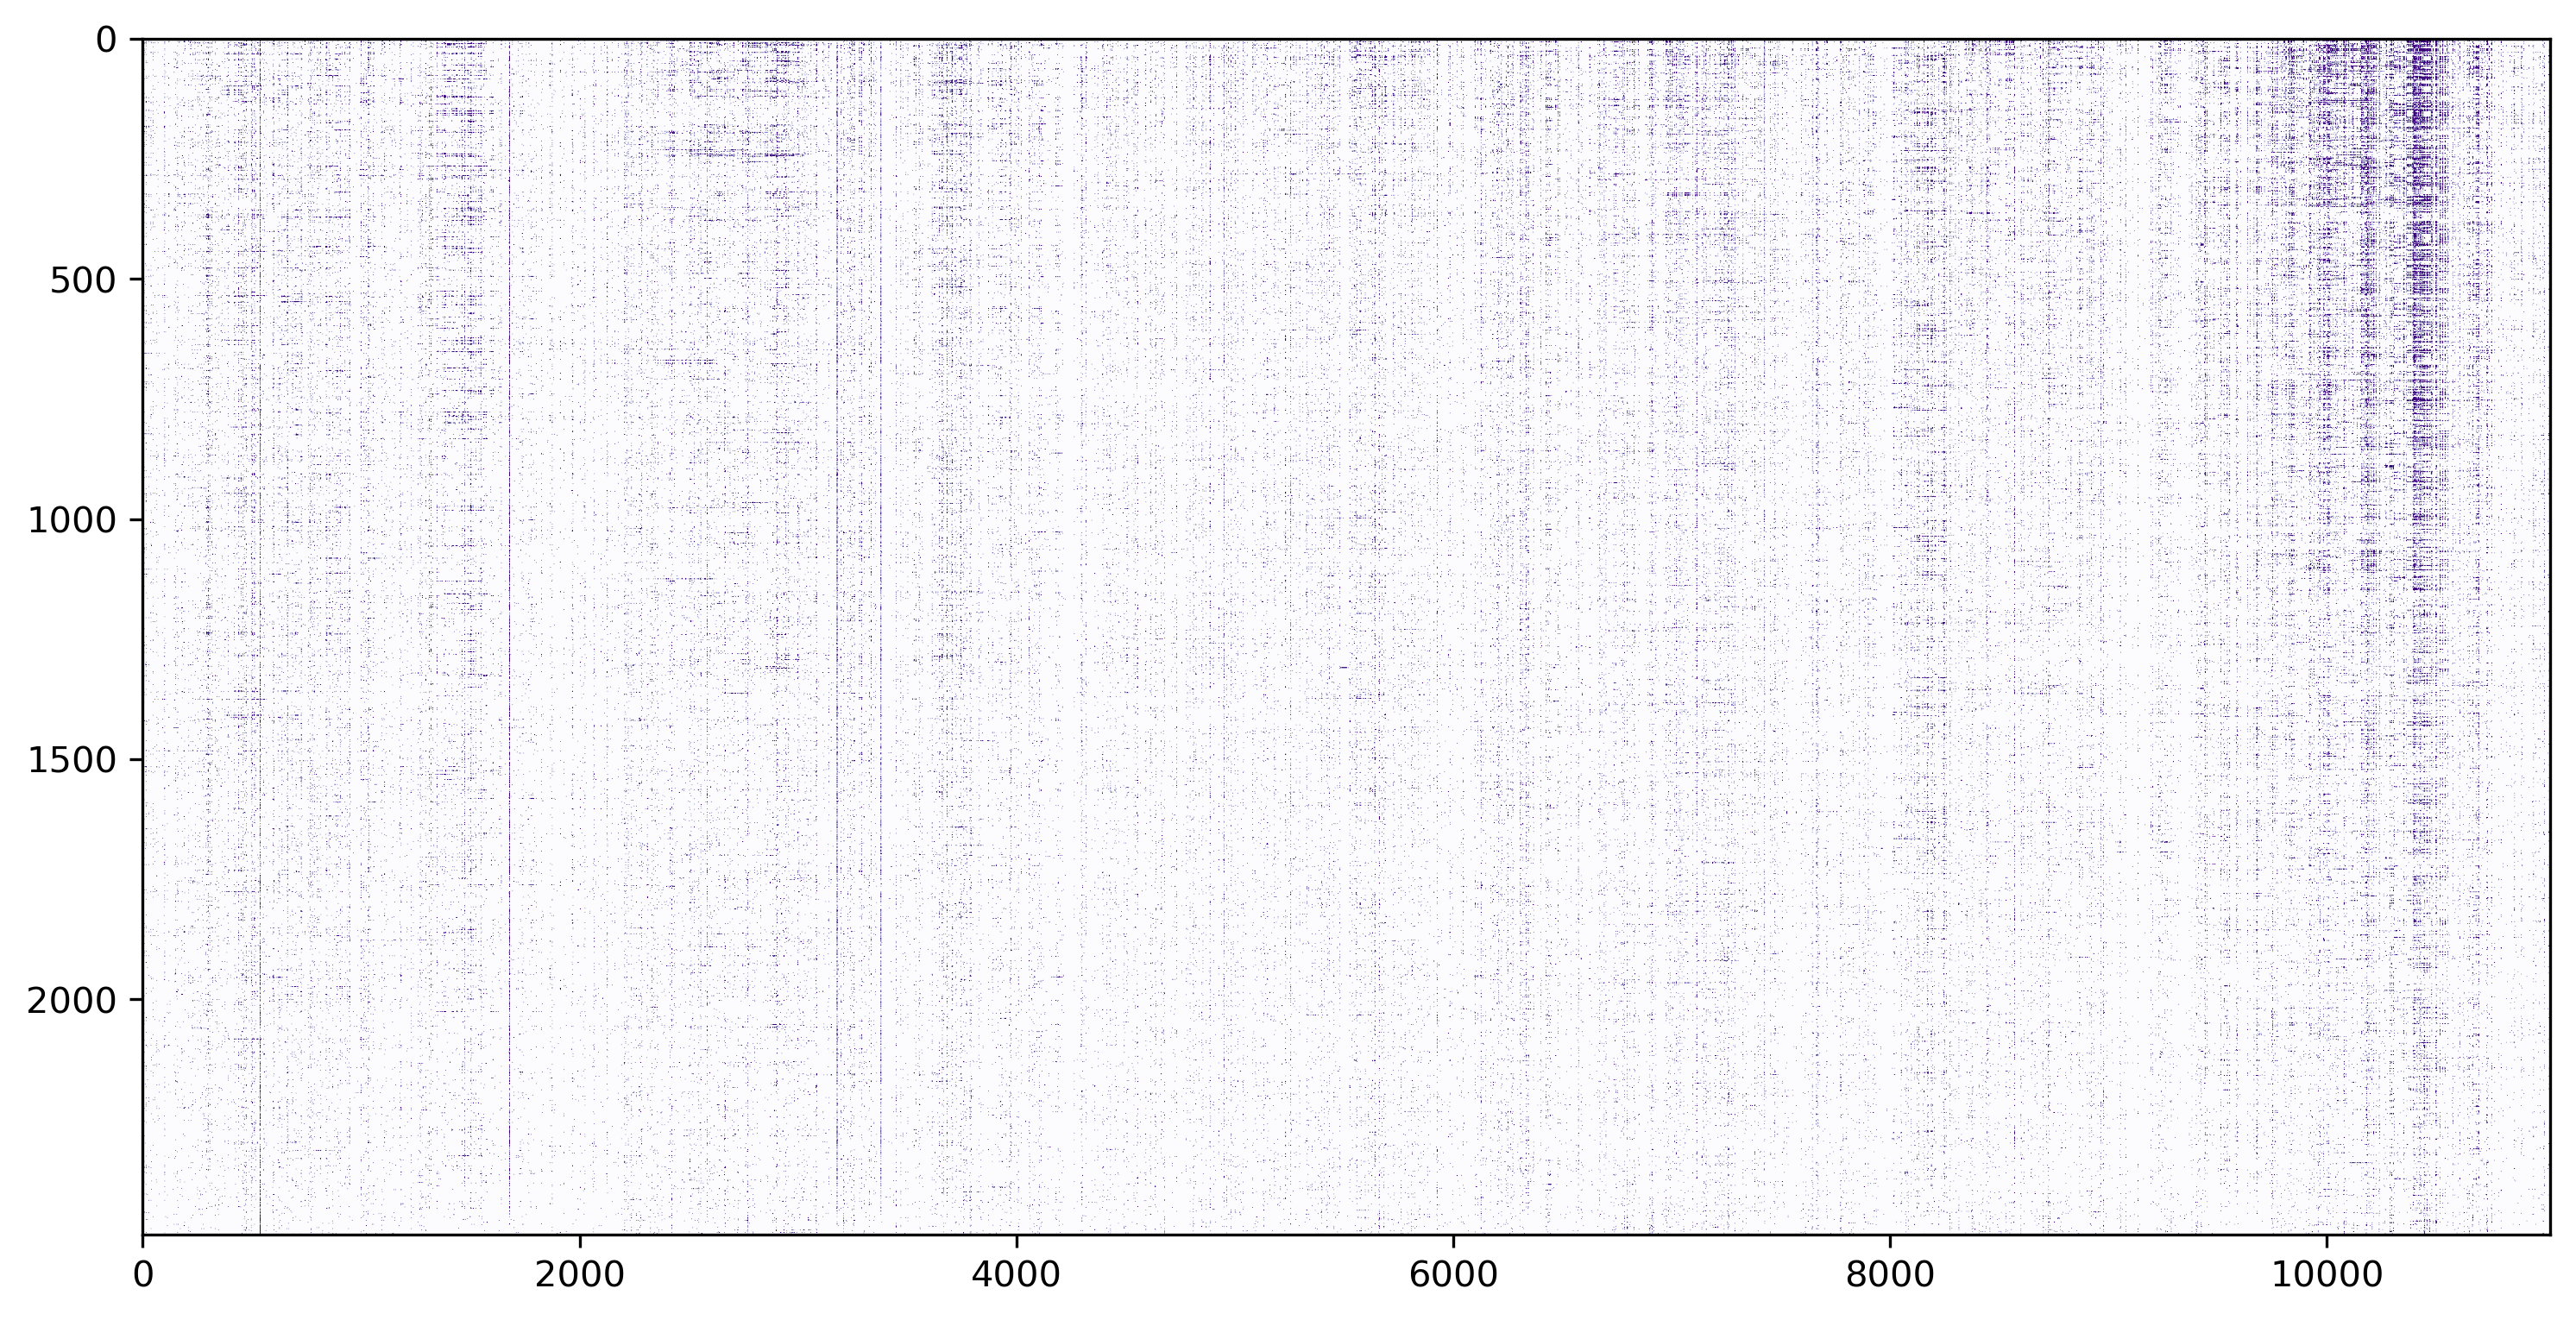

In [24]:
read_edit_num = np.sum(edits, axis=1)
plot_range =  np.arange(500, 5235754-5223731-500)

fig, ax = plt.subplots(dpi=300, figsize=(12, 6))

undel_filter = np.where(selected_del_flags == 0)[0]
row_order = [i for i in np.argsort(-read_edit_num)]
ax.imshow(edits[row_order, :][:, plot_range], aspect='auto', vmax=0.2, vmin=0, cmap="Purples")

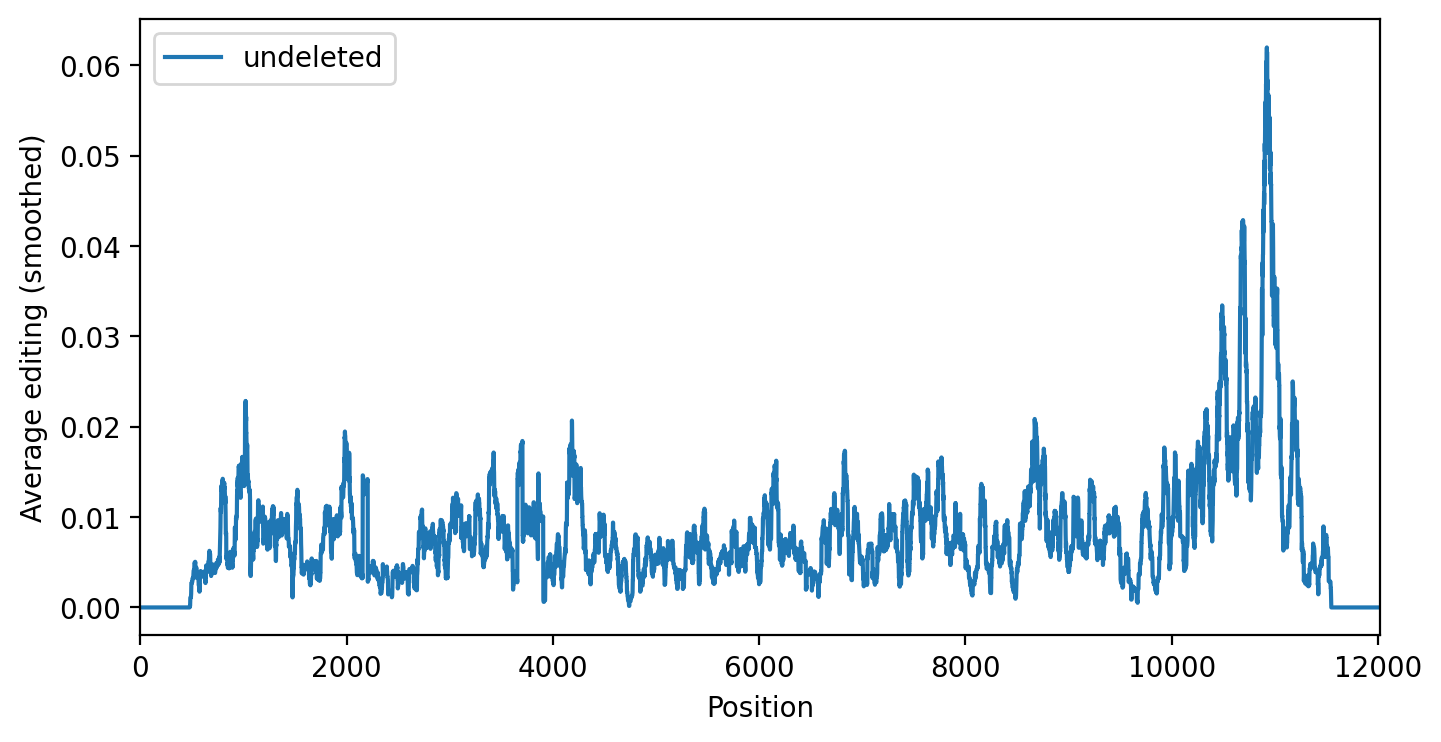

In [25]:
# Calculate average editing rate for each condition
track_undeleted_ac = np.mean(edits[np.array(selected_del_flags) == 0, :], axis = 0)

# Smooth tracks
track_undeleted_ac_smoothed = np.convolve(track_undeleted_ac, np.ones(50),mode='same')/50

# Visualize results
plt.figure(dpi=200, figsize=(8, 4))

plt.plot(np.arange(len(track_undeleted_ac_smoothed)), track_undeleted_ac_smoothed, label="undeleted")
plt.xlabel("Position")
plt.ylabel("Average editing (smoothed)")
plt.legend()
plt.xlim(0, len(track_undeleted_ac_smoothed) - 1)

plt.show()

In [28]:
with open('/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR234/track_undeleted_ac_HJR234_2_dedup.pkl', 'wb') as f:
    pickle.dump(track_undeleted_ac_smoothed , f)

In [27]:
with open('/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR234/edits_HJR234_2_dedup.pkl', 'wb') as f:
    pickle.dump(edits[row_order, :] , f)